In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the script and dataset
FOLDERNAME = 'SMM636/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


Face recognition via eigenface and SVM
=============================================

This example is from <https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html#sphx-glr-download-packages-scikit-learn-auto-examples-plot-eigenfaces-py>. 

The aim of this tutorial is to 1) know how to use PCA in Python and 2) how to use the results of PCA in subsequent analysis. Here we apply PCA on face images and obtain eigenfaces, i.e. the first few PCs. We then use SVM to classify faces by using their PC scores obtained from PCA.


In [1]:
%matplotlib inline

In [2]:
from sklearn import datasets
faces = datasets.fetch_olivetti_faces() #we first import the Olivetti faces <https://scikit-learn.org/0.19/datasets/olivetti_faces.html>
faces.data.shape # There are ten different images of each of 40 distinct subjects. 

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Mattheus\scikit_learn_data


(400, 4096)

Let's have a look at few examples of the faces we will use.



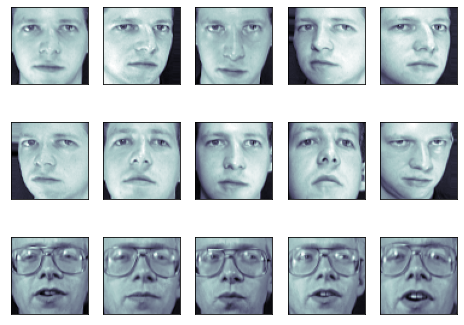

In [3]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 6))
# plot few examples. The images are captured in different directions, under different lighting, with different facial expressions etc.
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone) #cmap is to set the colour map <https://matplotlib.org/stable/tutorials/colors/colormaps.html>

In [4]:
from sklearn.model_selection import train_test_split
# get training and test sets
X_train, X_test, y_train, y_test = train_test_split(faces.data,
        faces.target, random_state=0)

print(X_train.shape, X_test.shape)

(300, 4096) (100, 4096)


The face images live in a high-dimensional space, so we aim to reduce the dimension for more efficient subsequent analysis.

In [5]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=150, whiten=True) 
# <https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html>
# whitening is to make the PCs with unit variance.
pca.fit(X_train)

PCA(n_components=150, whiten=True)

We can obtain the mean face from the output of PCA.



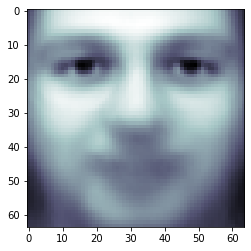

In [6]:
plt.imshow(pca.mean_.reshape(faces.images[0].shape),
           cmap=plt.cm.bone)

In [7]:
print(pca.components_.shape)

(150, 4096)


It is also interesting to visualise the PCs:



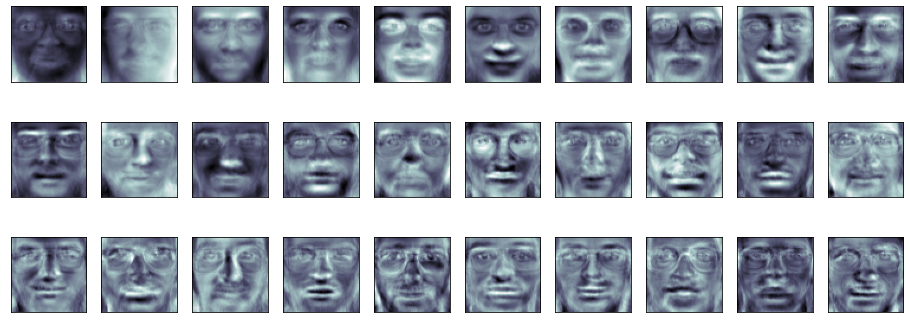

In [8]:
fig = plt.figure(figsize=(16, 6))
for i in range(30): #visualise the first 30 PCs
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)

The components ("eigenfaces") are ordered by their importance from
top-left to bottom-right. We see that the first few components seem to
primarily take care of lighting conditions; the remaining components
pull out certain identifying features: the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training
and test data onto the PCA basis:



In [9]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

(300, 150)


In [10]:
print(X_test_pca.shape)

(100, 150)


Apply SVM on the PC scores


In [11]:
from sklearn import svm
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

SVC(C=5.0, gamma=0.001)

Finally, we can evaluate how well this classification did. First, we
might plot a few of the test-cases with the labels learned from the
training set:



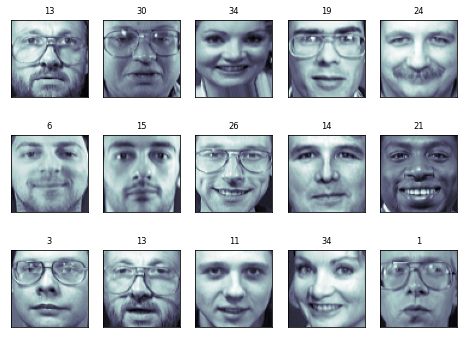

In [12]:
import numpy as np
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

In [13]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
# have a look at the evaluation metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       1.00      1.00      1.00         4
           2       0.50      1.00      0.67         2
           3       1.00      1.00      1.00         1
           4       0.33      1.00      0.50         1
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4
           7       1.00      0.67      0.80         3
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         5
          15       0.75      1.00      0.86         3
          17       1.00      1.00      1.00         6
          19       1.00      1.00      1.00         4
          20       1.00    

Pipelining
----------

Above we used PCA as a pre-processing step before applying our support
vector machine classifier. Plugging the output of one estimator directly
into the input of a second estimator is a commonly used pattern; for
this reason scikit-learn provides a ``Pipeline`` object which automates
this process. The above problem can be re-expressed as a pipeline as
follows:



In [14]:
from sklearn.pipeline import Pipeline
clf = Pipeline([('pca', decomposition.PCA(n_components=150, whiten=True)),
                ('svm', svm.SVC(C=5., gamma=0.001))])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       1.00      1.00      1.00         4
           2       0.50      1.00      0.67         2
           3       1.00      1.00      1.00         1
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4
           7       1.00      0.67      0.80         3
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         1
          12       0.67      1.00      0.80         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         6
          19       1.00      1.00      1.00         4
          20       1.00    